In [11]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate


!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import torch.optim as optim
import torchvision.transforms as transforms
from datasets import load_dataset, Dataset



from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder

from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
    AutoConfig
)

In [13]:
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: data/Part1Intr.mp4      
   creating: data/test_data/
  inflating: data/test_data/0002_0.jpg  
  inflating: data/test_data/0007_0.jpg  
  inflating: data/test_data/0009_0.jpg  
  inflating: data/test_data/0012_0.jpg  
  inflating: data/test_data/0019_0.jpg  
  inflating: data/test_data/0033_0.jpg  
  inflating: data/test_data/0035_0.jpg  
  inflating: data/test_data/0049_0.jpg  
  inflating: data/test_data/0052_0.jpg  
  inflating: data/test_data/0053_0.jpg  
  inflating: data/test_data/0054_0.jpg  
  inflating: data/test_data/0058_0.jpg  
  inflating: data/test_data/0064_0.jpg  
  inflating: data/test_data/0080_0.jpg  
  inflating: data/test_data/0089_0.jpg  
  inflating: data/test_data/0094_0.jpg  
  inflating: data/test_data/0101_0.jpg  
  inflating: data/test_data/0104_0.jpg  
  inflating: data/test_data/0107_0.jpg  
  inflating: data/test_data/0117_0.jpg  
  inflating: data/test_data/0121_0.jpg  
  inflating: data/test_data/0124_0.jpg  
  i

In [14]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 16
    EPOCHS:        int = 50
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = '/content/data'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

In [17]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=64, transforms=None):
        self.root_dir = root_dir
        self.df = df.reset_index(drop=True)  # Reset index to avoid potential indexing issues
        self.processor = processor
        self.max_target_length = max_target_length
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx >= len(self.df):  # Debugging check to avoid out-of-bounds index
            raise IndexError(f"Index {idx} out of range for dataset with length {len(self.df)}")

        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['texteng'][idx]

        # Read the image
        image_path = os.path.join(self.root_dir, file_name)
        image = Image.open(image_path).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        # Apply processor
        pixel_values = self.processor(image, return_tensors='pt').pixel_values

        # Tokenize text labels
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids

        # Use -100 as padding token
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}


In [19]:
root_dir = '/content/data'  # The folder containing class folders

In [20]:
train_df, valid_df = pd.read_csv('/content/data/train1.csv'), pd.read_csv('/content/data/val1.csv')
len(train_df),len(valid_df)

(1335, 334)

In [21]:
valid_df.head()

,file_name,text
0,0807_0.jpg,و ١
1,0332_0.jpg,ب ط ل ١١١١
2,0991_0.jpg,ط ر ١
3,1625_0.jpg,ع ع ٢
4,1609_0.jpg,م ن ى ٦٦٦٦


In [22]:
train_df.head()

,file_name,text
0,0028_0.jpg,ص ق د ١١٤٢
1,0301_0.jpg,ع ٤
2,0391_0.jpg,ى ى ٥٥٥٥
3,1795_0.jpg,ق م س ٧٩٤٢
4,0156_0.jpg,أ ه م ٥٥٥


In [23]:
valid_df.isna().sum() , train_df.isna().sum()

(file_name    2
 text         2
 dtype: int64,
 file_name    11
 text         12
 dtype: int64)

In [24]:
train_df.dropna(inplace=True)
valid_df.dropna(inplace=True)

In [25]:
valid_df.isna().sum() , train_df.isna().sum()

(file_name    0
 text         0
 dtype: int64,
 file_name    0
 text         0
 dtype: int64)

In [26]:
# Mapping of Arabic to English numerals
arabic_to_english = str.maketrans('٠١٢٣٤٥٦٧٨٩', '0123456789')

# Convert the numerals in the 'text' column
train_df['texteng'] = train_df['text'].apply(lambda x: x.translate(arabic_to_english))
valid_df['texteng'] = valid_df['text'].apply(lambda x: x.translate(arabic_to_english))


In [27]:
train_df

,file_name,text,texteng
0,0028_0.jpg,ص ق د ١١٤٢,ص ق د 1142
1,0301_0.jpg,ع ٤,ع 4
2,0391_0.jpg,ى ى ٥٥٥٥,ى ى 5555
3,1795_0.jpg,ق م س ٧٩٤٢,ق م س 7942
4,0156_0.jpg,أ ه م ٥٥٥,أ ه م 555
...,...,...,...
1330,1603_0.jpg,ن و ر ٦,ن و ر 6
1331,1848_0.jpg,ن م ى ٩١٤,ن م ى 914
1332,1718_0.jpg,م س أ ١١١١,م س أ 1111
1333,1097_0.jpg,ن س ر ٨٨٨,ن س ر 888


In [28]:
valid_df.head()

,file_name,text,texteng
0,0807_0.jpg,و ١,و 1
1,0332_0.jpg,ب ط ل ١١١١,ب ط ل 1111
2,0991_0.jpg,ط ر ١,ط ر 1
3,1625_0.jpg,ع ع ٢,ع ع 2
4,1609_0.jpg,م ن ى ٦٦٦٦,م ن ى 6666


In [29]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

# train transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to model input size
])

#validation and test transform
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to model input size

])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [30]:
# Create datasets
train_dataset = CustomOCRDataset(root_dir='/content/data/train_data', df=train_df, processor=processor, transforms=train_transform)
valid_dataset = CustomOCRDataset(root_dir='/content/data/val_data', df=valid_df, processor=processor, transforms=valid_transform)

In [31]:
print(f"Train size: {len(train_dataset)}, Valid size: {len(valid_dataset)}")

Train size: 1323, Valid size: 332


In [32]:
train_dataset[0]

{'pixel_values': tensor([[[-0.8902, -0.8902, -0.8824,  ..., -0.9373, -0.9373, -0.9373],
          [-0.8902, -0.8902, -0.8824,  ..., -0.9373, -0.9373, -0.9373],
          [-0.8902, -0.8902, -0.8824,  ..., -0.9373, -0.9373, -0.9373],
          ...,
          [-0.8667, -0.8667, -0.8667,  ..., -0.8510, -0.8510, -0.8510],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8510, -0.8510, -0.8510],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8510, -0.8510, -0.8510]],
 
         [[-0.8510, -0.8510, -0.8431,  ..., -0.9373, -0.9373, -0.9373],
          [-0.8510, -0.8510, -0.8431,  ..., -0.9373, -0.9373, -0.9373],
          [-0.8510, -0.8510, -0.8431,  ..., -0.9373, -0.9373, -0.9373],
          ...,
          [-0.8824, -0.8824, -0.8824,  ..., -0.8902, -0.8902, -0.8902],
          [-0.8824, -0.8824, -0.8824,  ..., -0.8902, -0.8902, -0.8902],
          [-0.8824, -0.8824, -0.8824,  ..., -0.8902, -0.8902, -0.8902]],
 
         [[-0.8196, -0.8196, -0.8118,  ..., -0.8431, -0.8431, -0.8431],
          [-

Training Set Samples:


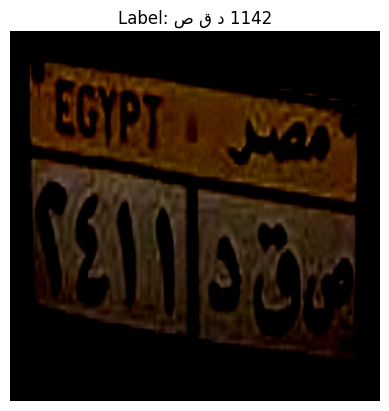

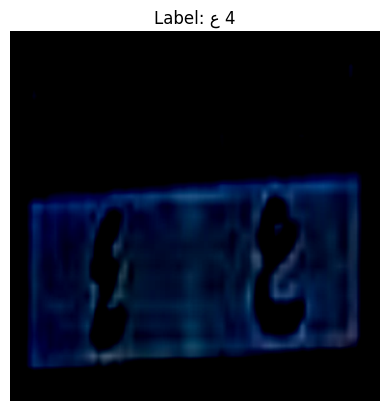

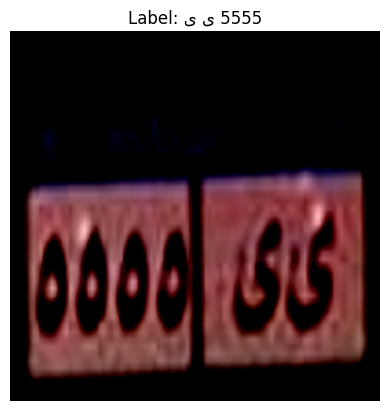

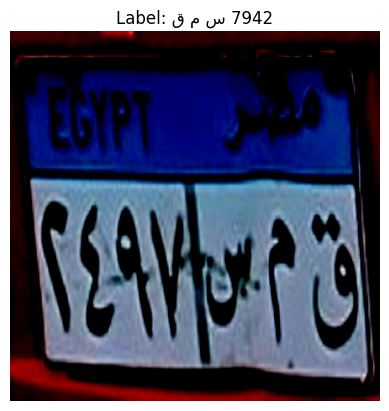

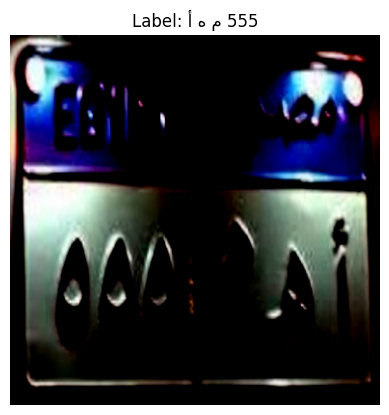


Validation Set Samples:


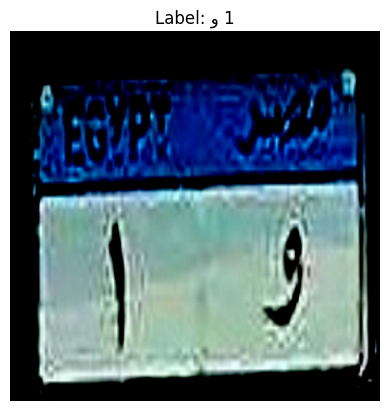

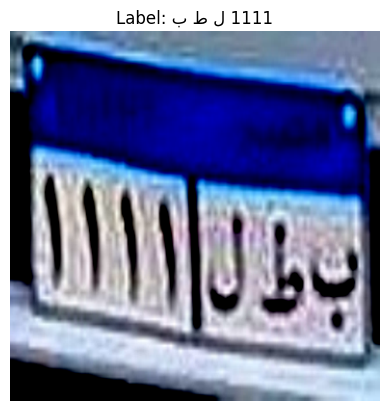

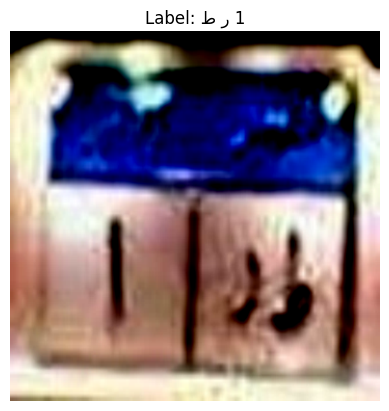

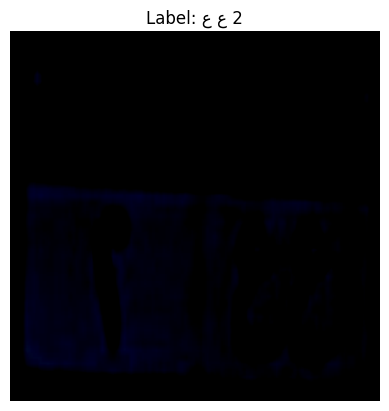

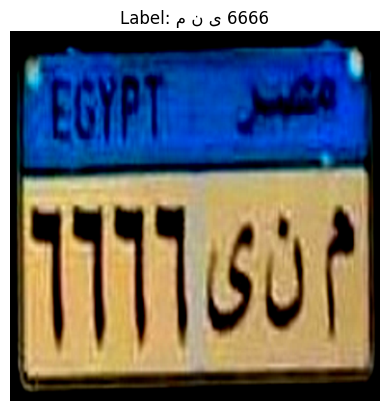

In [33]:
# Function to display images and their labels
def display_samples(dataset, num_samples=5):
    for i in range(num_samples):
        sample = dataset[i]
        pixel_values = sample['pixel_values']
        label = sample['labels']

        # Convert pixel values to image
        image = pixel_values.permute(1, 2, 0).numpy()

        # Convert label to text
        valid_label_indices = [idx for idx in label if 0 <= idx < processor.tokenizer.vocab_size]

        # Convert label to text using only valid token IDs
        text = processor.decode(valid_label_indices, skip_special_tokens=True)

        plt.figure()
        plt.imshow(image)
        plt.title(f"Label: {text}")
        plt.axis('off')
    plt.show()

# Display samples from the training set
print("Training Set Samples:")
display_samples(train_dataset)

# Display samples from the validation set
print("\nValidation Set Samples:")
display_samples(valid_dataset)

In [34]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

In [35]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id


model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


In [36]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [37]:
cer_metric = evaluate.load('cer')
def compute_cer(pred):
    # Decode predictions
    pred_str = processor.batch_decode(pred.predictions, skip_special_tokens=True)

    # Decode labels
    labels_ids = pred.label_ids
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    # Filter out empty strings from references
    filtered_pred_str = []
    filtered_label_str = []

    for p, l in zip(pred_str, label_str):
        if l.strip():  # Only include non-empty labels
            filtered_pred_str.append(p)
            filtered_label_str.append(l)

    # Compute CER only on valid entries
    cer = cer_metric.compute(predictions=filtered_pred_str, references=filtered_label_str)

    return {"cer": cer}


In [38]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='none',
    num_train_epochs=TrainingConfig.EPOCHS
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [40]:
!pip install wandb

In [41]:
import wandb
wandb.init(mode="disabled")

In [42]:
# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    processing_class=processor.image_processor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

In [43]:
res = trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,4.191100,1.944586,0.694928
2,1.707300,1.136793,0.342754
3,0.919700,0.573595,0.159420
4,0.451100,0.339955,0.108333
5,0.233400,0.203904,0.056159
6,0.158900,0.359963,0.096377
7,0.115500,0.195607,0.045652
8,0.082000,0.183219,0.054710
9,0.067700,0.113484,0.027899
10,0.075100,0.110145,0.030435


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tra

Epoch,Training Loss,Validation Loss,Cer
1,4.191100,1.944586,0.694928
2,1.707300,1.136793,0.342754
3,0.919700,0.573595,0.159420
4,0.451100,0.339955,0.108333
5,0.233400,0.203904,0.056159
6,0.158900,0.359963,0.096377
7,0.115500,0.195607,0.045652
8,0.082000,0.183219,0.054710
9,0.067700,0.113484,0.027899
10,0.075100,0.110145,0.030435


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

In [47]:
trainer.evaluate(eval_dataset=valid_dataset)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'eval_loss': 0.11353261023759842,
 'eval_cer': 0.01884057971014493,
 'eval_runtime': 15.3942,
 'eval_samples_per_second': 21.567,
 'eval_steps_per_second': 1.364,
 'epoch': 50.0}

Resolving data files:   0%|          | 0/417 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

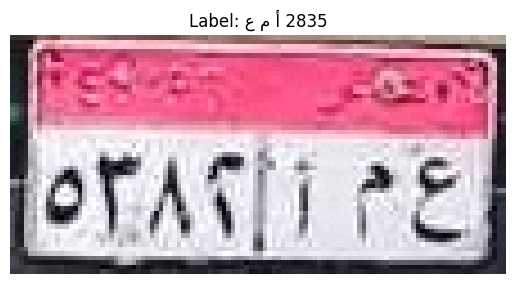

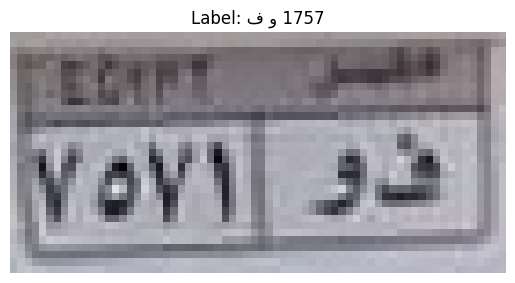

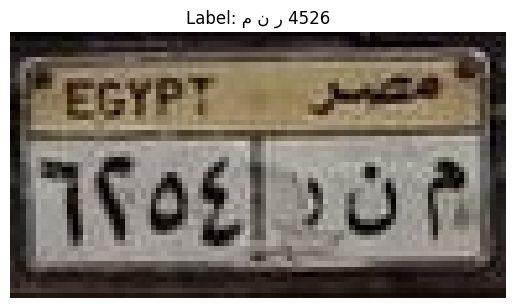

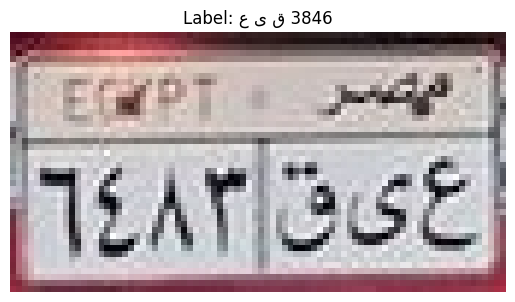

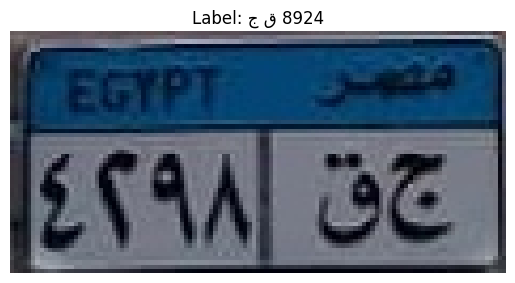

In [62]:
# Load test dataset, keeping the image paths
test_dataset = load_dataset('imagefolder', data_dir='/content/data/test_data', split='train')

# Store the image paths before preprocessing
image_paths = test_dataset['image']  # Extract the image paths
# Store the corresponding paths
image_paths = [image.filename for image in image_paths]


# Define a function to convert dataset to the expected format
def preprocess_function(examples):
    images = [image.convert("RGB") for image in examples['image']]
    pixel_values = processor(images, return_tensors="pt").pixel_values
    return {"pixel_values": pixel_values}

# Apply the preprocessing function to dataset
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=['image'])
test_dataset.set_format(type="torch", columns=['pixel_values'])


trainer.data_collator = default_data_collator


predictions = trainer.predict(test_dataset)


predicted_texts = processor.batch_decode(predictions.predictions, skip_special_tokens=True)

# Print predictions alongside image paths, accessing paths from the stored list
for i, predicted_text in enumerate(predicted_texts[:5]):
    image_path = image_paths[i]  # Access paths from the stored list
    image = Image.open(image_path).convert("RGB")
    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {predicted_text}")
    plt.axis("off")
    plt.show()

In [49]:
# Zip the directory
!zip -r /content/seq2seq_model_printed.zip /content/seq2seq_model_printed

  adding: content/seq2seq_model_printed/ (stored 0%)
  adding: content/seq2seq_model_printed/checkpoint-4067/ (stored 0%)
  adding: content/seq2seq_model_printed/checkpoint-4067/config.json (deflated 77%)
  adding: content/seq2seq_model_printed/checkpoint-4067/trainer_state.json (deflated 83%)
  adding: content/seq2seq_model_printed/checkpoint-4067/scheduler.pt (deflated 55%)
  adding: content/seq2seq_model_printed/checkpoint-4067/optimizer.pt (deflated 32%)
  adding: content/seq2seq_model_printed/checkpoint-4067/model.safetensors (deflated 16%)
  adding: content/seq2seq_model_printed/checkpoint-4067/training_args.bin (deflated 52%)
  adding: content/seq2seq_model_printed/checkpoint-4067/rng_state.pth (deflated 25%)
  adding: content/seq2seq_model_printed/checkpoint-4067/generation_config.json (deflated 40%)
  adding: content/seq2seq_model_printed/checkpoint-4067/preprocessor_config.json (deflated 52%)
  adding: content/seq2seq_model_printed/checkpoint-3901/ (stored 0%)
  adding: conte

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
from google.colab import files
files.download("/content/seq2seq_model_printed.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>